In [51]:
from fuzzywuzzy import process, fuzz
import re
import matplotlib.pyplot as plt
import numpy as np
from rapidfuzz import fuzz
import os
import json
import string
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from sentence_transformers import SentenceTransformer, util
import requests
from bs4 import BeautifulSoup
from io import StringIO

### Parsing prices data from web pages

In [52]:
# Getting the html page
import requests

URL_base = "https://osservaprezzi.mise.gov.it/prezzi/livelli/beni-e-servizi-di-largo-consumo/archivio-rilevazioni-beni-e-servizi-di-largo-consumo?ANNO=2025&MESE=5&f%5BPROVINCIA%5D=Bologna&f%5BTIPO_RECORD_MISE%5D="
URL_alimenti = "altri_alim&submit=Applica"
URL_ortofrutta = "orto&submit=Applica"
page_alimenti = requests.get(URL_base+URL_alimenti)
page_ortofrutta = requests.get(URL_base+URL_ortofrutta)

print(page_alimenti.text)

<!DOCTYPE html>
<!--[if IE 8]><html class="no-js ie89 ie8" lang="it-it"><![endif]-->
<!--[if IE 9]><html class="no-js ie89 ie9" lang="it-it"><![endif]-->
<!--[if (gte IE 9)|!(IE)]><!-->
<html class="no-js theme-italia" lang="it-it" dir="ltr">
<!--<![endif]-->
<head>
	<meta charset="utf-8" />
	<meta http-equiv="x-ua-compatible" content="ie=edge">
	<meta name="viewport" content="width=device-width, initial-scale=1">

		<!--[if lt IE 9]><script src="/media/jui/js/html5.js"></script><![endif]-->
	<!-- include html5shim per Explorer 8 -->
	<script src="https://osservaprezzi.mise.gov.it/templates/italiapa/build/vendor/modernizr.js"></script>

	<script>__PUBLIC_PATH__ = 'https://osservaprezzi.mise.gov.it/templates/italiapa/build/'</script>
	<script>__DEFAULT_THEME__ = 'italia'</script>

	<link href='//fonts.googleapis.com/css?family=Titillium+Web:400,400italic,700,' rel='stylesheet' type='text/css' />
	<link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">

	<b

In [53]:
# parsing the page with BeautifulSoup
soup_al = BeautifulSoup(page_alimenti.content, "html.parser")
soup_ort = BeautifulSoup(page_ortofrutta.content, "html.parser")

In [54]:
# finding the table with id "id-table-results"
results_alimenti = soup_al.find(id="id-table-results")
results_orto = soup_ort.find(id="id-table-results")

In [55]:
# Transform the table into a pandas dataframe
df_prices_alimenti = pd.read_html(StringIO(str(results_alimenti)))[0]

df_prices_orto = pd.read_html(StringIO(str(results_orto)))[0]

prices_data = pd.concat([df_prices_alimenti, df_prices_orto], ignore_index=True)

In [56]:
prices_data

,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto
0,Riso (1000 Gr),1.91,5.45,3.10,Alimentari
1,Farina Di Frumento (1000 Gr),0.48,2.13,0.95,Alimentari
2,Pane Fresco Con Farina Di Grano (1000 Gr),3.99,7.80,5.23,Alimentari
3,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari
4,Biscotti (1000 Gr),2.68,7.65,4.24,Alimentari
...,...,...,...,...,...
70,Cipolle Rosse (1000 Gr),1.60,4.00,2.10,Ortofrutta
71,Cipolle Dorate Di Parma E Gialle (1000 Gr),1.31,2.76,1.75,Ortofrutta
72,Agli Bianchi Secchi (1000 Gr),5.90,12.62,10.08,Ortofrutta
73,Patate Primura (1000 Gr),1.50,2.01,1.78,Ortofrutta


In [57]:
# Initialize SPARQL endpoint and model
sparql = SPARQLWrapper("http://agrovoc.fao.org/sparql")
model = SentenceTransformer('all-MiniLM-L6-v2')

CACHE_PATH = "agro_cache.json"

In [58]:
def load_cache():
    if not os.path.exists(CACHE_PATH):
        return {}
    with open(CACHE_PATH, "r", encoding="utf-8") as f:
        cache = json.load(f)
        return cache

def save_cache(cache):
    with open(CACHE_PATH, "w", encoding="utf-8") as f:
        json.dump(cache, f, indent=2)

In [59]:
def semantic_best_match(value, candidates):
    input_embedding = model.encode(value, convert_to_tensor=True)
    candidate_texts = []
    for c in candidates:
        candidate_texts.append(c["label"])
    candidate_embeddings = model.encode(candidate_texts, convert_to_tensor=True)
    scores = util.cos_sim(input_embedding, candidate_embeddings)[0]
    best_idx = scores.argmax().item()
    return candidates[best_idx]

In [60]:
def query_agrovoc(value, cache):


    if value in cache:
        print(f"Cache hit: '{value}' found in cache")
        return cache[value]
    
    print(f"Cache miss: '{value}' not in cache, querying AGROVOC endpoint")
    # Run SPARQL query
    query = f"""
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    SELECT ?concept ?label WHERE {{
        ?concept skos:prefLabel ?label .
        FILTER(LANG(?label) = "en" && REGEX(?label, "{value}", "i"))
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    candidates = []
    for result in results["results"]["bindings"]:
        label = result["label"]["value"]
        uri = result["concept"]["value"]
        candidate = {"label": label, "uri": uri}
        candidates.append(candidate)
    if not candidates:
        match = {"label": None, "uri": None}
    else:
        best = semantic_best_match(value, candidates)
        match = best
    # Cache the result
    cache[value] = match
    save_cache(cache)
    return match

In [61]:
def enrich_with_agrovoc(df, column_name):
    cache = load_cache()
    labels = []
    uris = []
    for val in df[column_name]:
        match = query_agrovoc(val, cache)
        labels.append(match["label"])
        uris.append(match["uri"])
    df["AGROVOC_label"] = labels
    df["AGROVOC_uri"] = uris
    return df

In [62]:
# Load the food consumption data
df_consumption = pd.read_csv("data/chronic_consumption_gday_allsubjects.csv", encoding="utf-16")

# Load the SuEatableLife dataset
df_wf = pd.read_excel("data/sueatablelife_dataset.xlsx", sheet_name="SEL WF for users")
df_cf = pd.read_excel("data/sueatablelife_dataset.xlsx", sheet_name="SEL CF for users")

In [63]:
# Remove water from the consumption data
df_consumption = df_consumption[(df_consumption["Exposure hierarchy (L7)"] != "Natural mineral water") &
    (df_consumption["Exposure hierarchy (L7)"] != "Tap water") &
    (df_consumption["Exposure hierarchy (L7)"] != "Filtered tap water")]

# Group by "Exposure hierarchy (L5)" and sum the "Mean" values
top_n = df_consumption.groupby("Exposure hierarchy (L5)", as_index=False)["Mean"].sum().sort_values('Mean', ascending=False).head(15)

top_n[["Exposure hierarchy (L5)", "Mean"]]

,Exposure hierarchy (L5),Mean
147,Cow milk,307.48
120,Coffee (average strength) beverage,175.78
8,Apples,134.45
524,Tomatoes,134.18
396,Potatoes,123.47
554,"Wheat bread and rolls, white (refined flour)",122.61
565,"Wine, red",108.29
95,Chicken fresh meat,99.33
177,Dried pasta,88.81
126,"Cola beverages, caffeinic",85.10


In [64]:
# Merge coffee rows and milk rows
rows_to_merge = top_n[top_n["Exposure hierarchy (L5)"].isin(["Coffee (average strength) beverage", "Coffee espresso (beverage)"])]
merged_row = rows_to_merge.sum(numeric_only=True)
merged_row["Exposure hierarchy (L5)"] = "Coffee"

# Drop the original rows and append the merged row
top_n = top_n[~top_n["Exposure hierarchy (L5)"].isin(["Coffee (average strength) beverage", "Coffee espresso (beverage)"])]
top_n = pd.concat([top_n, pd.DataFrame([merged_row])], ignore_index=True)

In [65]:
# Sort again by "Mean" values to include the merged rows
top_n = top_n.sort_values("Mean", ascending=False).reset_index(drop=True)

top_n

,Exposure hierarchy (L5),Mean
0,Cow milk,307.48
1,Coffee,253.19
2,Apples,134.45
3,Tomatoes,134.18
4,Potatoes,123.47
5,"Wheat bread and rolls, white (refined flour)",122.61
6,"Wine, red",108.29
7,Chicken fresh meat,99.33
8,Dried pasta,88.81
9,"Cola beverages, caffeinic",85.10


In [66]:
# Enrich the top_n DataFrame with AGROVOC labels and URIs
top_n_enriched = enrich_with_agrovoc(top_n, "Exposure hierarchy (L5)")

top_n_enriched

Cache hit: 'Cow milk' found in cache
Cache hit: 'Coffee' found in cache
Cache hit: 'Apples' found in cache
Cache hit: 'Tomatoes' found in cache
Cache hit: 'Potatoes' found in cache
Cache hit: 'Wheat bread and rolls, white (refined flour)' found in cache
Cache hit: 'Wine, red' found in cache
Cache hit: 'Chicken fresh meat' found in cache
Cache hit: 'Dried pasta' found in cache
Cache hit: 'Cola beverages, caffeinic' found in cache
Cache hit: 'Olive oil, virgin or extra-virgin' found in cache
Cache hit: 'Beer' found in cache
Cache hit: 'Cow, ox or bull fresh meat' found in cache
Cache hit: 'Common peaches' found in cache


,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805
4,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551
5,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071
6,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614
7,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000
8,Dried pasta,88.81,pasta,http://aims.fao.org/aos/agrovoc/c_5621
9,"Cola beverages, caffeinic",85.10,soft drinks,http://aims.fao.org/aos/agrovoc/c_7149


In [67]:
# Functions for pre-processing
# Function to singularize English words based on common pluralization rules.
# List of (pattern, replacement) in priority order:
PLURAL_RULES = [
    # -ies → -y      (e.g. “berries” → “berry”)
    (r'(?i)([a-z]+)ies$', r'\1y'),
    # -ves → -f      (e.g. “wolves” → “wolf”)
    (r'(?i)([a-z]+)ves$', r'\1f'),
    # -oes → -oe     (e.g. “heroes” → “heroe”—rare, you may want 'o')
    (r'(?i)([a-z]+)oes$', r'\1oe'),
    # -ses → -s      (e.g. “dresses” → “dress”)
    (r'(?i)([a-z]+)ses$', r'\1s'),
    # -xes → -x      (e.g. “boxes” → “box”)
    (r'(?i)([a-z]+)xes$', r'\1x'),
    # -ches/-shes → -ch/-sh  (e.g. “churches” → “church”)
    (r'(?i)([a-z]+(?:ch|sh))es$', r'\1'),
    # -s → ''        (catch‑all; e.g. “cars” → “car”)
    (r'(?i)([a-z]+)s$', r'\1'),
]

def singularize(word: str) -> str:
    """Apply common English plural→singular regex rules."""
    for pattern, repl in PLURAL_RULES:
        if re.search(pattern, word):
            return re.sub(pattern, repl, word)
    return word  # no rule matched

In [68]:
# Function to normalize labels
def normalize_label(s, language='en'):
    s = s.lower().strip().replace('-', ' ').replace('_', ' ')
     # Remove numbers and letters in brackets, asteriks, punctuation
    s = re.sub(r'\(.*?\)', '', s)  # Remove text in brackets
    s = re.sub(r'\d+', '', s)  # Remove numbers
    s = re.sub(r'\*', '', s)  # Remove asterisks
    s = re.sub(r'[^a-z0-9 ]+', ' ', s)       # drop punctuation
    s = re.sub(r'\b(semi[- ]skimmed|organic|low[- ]fat)\b', '', s)
    s = re.sub(r'\s+', ' ', s)               # collapse whitespace
    s = re.sub(r"(fresh|caffeinic|common)", "", s) # remove common useless attributes
    s = re.sub(r"wheat bread", "bread", s)
    s = s.strip()  # Remove leading and trailing whitespace
    s = re.sub(r"meat", "", s) # remove meat to improve the results of fuzzy matching for different animal meat
    s = re.sub(r"or", "", s)
    # handling plurals
    if language == 'en':
        s = singularize(s)

    return s

In [69]:
# Normalize the AGROVOC labels of the first dataframe
top_n['clean_label'] = top_n["AGROVOC_label"].apply(normalize_label)

In [70]:
top_n

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe
4,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe
5,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread
6,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine
7,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken
8,Dried pasta,88.81,pasta,http://aims.fao.org/aos/agrovoc/c_5621,pasta
9,"Cola beverages, caffeinic",85.10,soft drinks,http://aims.fao.org/aos/agrovoc/c_7149,soft drink


In [71]:
# Normalize the labels in the other dataframes
df_cf['clean_label'] = df_cf["Food commodity ITEM"].apply(normalize_label)
df_wf['clean_label'] = df_wf["Food commodity ITEM"].apply(normalize_label)

In [72]:
# Function to create a mapping from a dataframe column to the closest values in another dataframe column using fuzzy matching
def create_fuzzy_mapping(source_df, target_df, source_col, target_col, score_cut):
    matches = {}
    for value in source_df[source_col]:
        result = process.extractOne(value, target_df[target_col], score_cutoff=score_cut)
        if result is not None:
            match, score, _ = result
            matches[value] = match
        # Keep unmatched values as None
        else:
            matches[value] = None
    return matches

In [73]:
matches = create_fuzzy_mapping(top_n, df_cf, 'clean_label', 'clean_label', 85)

In [74]:
# Add the matched food to the top_n DataFrame, but keep unmatched values as None
top_n['matched_food'] = top_n['clean_label'].map(matches)

In [75]:
# Merge the top_n DataFrame with the cF DataFrame on the matched food, keeping unmatched values as None
merged_df = top_n.merge(df_cf, left_on='matched_food', right_on='clean_label', how="left", suffixes=('_cons', '_cf'))

In [76]:
merged_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label_cf
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,OK item,MILK,1.437000,-,-,cow milk
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,better typology,COFFEE GROUND & PARCHMENT,6.710000,-,-,coffee ground
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,OK item,FRUIT OPENFIELD,0.400000,FRUIT OTHER,0.32,apple
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,OK item,VEGETABLES HEATED GREENHOUSE,2.550000,-,-,tomato
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,OK item,VEGETABLES NOT HEATED GREENHOUSE,1.180000,-,-,tomato
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,OK item,VEGETABLES OPENFIELD,0.330000,"VEGETABLES (fruits, steems, flowers)",0.33,tomato
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,OK item,STARCHY TUBERS,0.270000,-,-,potato
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,better typology,BREAD,0.860000,-,-,bread multicereal
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,OK item,WINE,0.660000,-,-,wine red
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,OK item,POULTRY BONE FREE MEAT,3.880596,-,-,chicken bone free


In [77]:
# Manually fix the data
# Search for coffee rows in the cF DataFrame

df_cf[df_cf["clean_label"].str.contains("coffe", case=False, na=False)]

,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label
13,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,better typology,COFFEE GROUND & PARCHMENT,6.71,-,-,coffee ground
14,AGRICULTURAL PROCESSED,COFFEE PARCHMENT,8.290000,L,OK item,COFFEE GROUND & PARCHMENT,6.71,-,-,coffee parchment
15,AGRICULTURAL PROCESSED,COFFEE DRIP FILTERED (L),0.595000,H,better typology,COFFEE LIQUID,0.55,-,-,coffee drip filtered
16,AGRICULTURAL PROCESSED,COFFEE SOLUBLE POWDER (L),0.330000,H,better typology,COFFEE LIQUID,0.55,-,-,coffee soluble powder
146,CROPS,COFFEE GREEN*,0.486000,L,OK item,COFFEE GREEN*,0.49,-,-,coffee green


In [78]:
# Choose the correct coffee row in the cF DataFrame
single_coffee_row = df_cf[df_cf["clean_label"] == "coffee drip filtered"]

In [79]:
# Function to substitute part of the rows in a DataFrame
# This function substitutes the last n columns of rows in df1 where the specified column matches value
def substitute_part_rows(df1, df2, value1, column_name, n_columns, df3=None, df4=None, value2=None, value3=None):
    for idx, row in df1.iterrows():
        if pd.isna(row[column_name]):
            continue
        if value1 in row[column_name].lower():
            df1.iloc[idx, -n_columns:] = df2.iloc[0,:n_columns].values
        if df3 is not None:
            if value2 in row[column_name].lower():
                df1.iloc[idx, -n_columns:] = df3.iloc[0,:n_columns].values
        if df4 is not None:
            if value3 in row[column_name].lower():
                df1.iloc[idx, -n_columns:] = df4.iloc[0,:n_columns].values

In [80]:
""" # Substitute the values in the merged DataFrame for the coffee row
for idx, row in merged_df.iterrows():
    if row["Food commodity ITEM"] == "COFFEE GROUND":
        merged_df.iloc[idx, -10:] = single_coffee_row.iloc[0,:10].values
        break """

# Use the function to substitute the values in the merged DataFrame for the coffee row
substitute_part_rows(merged_df, single_coffee_row, "COFFEE", "Food commodity ITEM", 10)

In [81]:
merged_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY,clean_label_cf
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,OK item,MILK,1.437000,-,-,cow milk
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,better typology,COFFEE GROUND & PARCHMENT,6.710000,-,-,coffee ground
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,OK item,FRUIT OPENFIELD,0.400000,FRUIT OTHER,0.32,apple
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,OK item,VEGETABLES HEATED GREENHOUSE,2.550000,-,-,tomato
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,OK item,VEGETABLES NOT HEATED GREENHOUSE,1.180000,-,-,tomato
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,OK item,VEGETABLES OPENFIELD,0.330000,"VEGETABLES (fruits, steems, flowers)",0.33,tomato
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,OK item,STARCHY TUBERS,0.270000,-,-,potato
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,better typology,BREAD,0.860000,-,-,bread multicereal
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,OK item,WINE,0.660000,-,-,wine red
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,OK item,POULTRY BONE FREE MEAT,3.880596,-,-,chicken bone free


In [82]:
merged_df.drop(columns=["Exposure hierarchy (L5)", "Uncertainty    low (L) high (H)", "matched_food", "FOOD COMMODITY GROUP", "Food commodity sub-TYPOLOGY", "Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY", "clean_label_cf"])

,Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,Food commodity ITEM,Carbon Footprint kg CO2eq/kg or l of food ITEM,Suggested CF value,Food commodity TYPOLOGY,Carbon Footprint g CO2eq/g o cc of food TYPOLOGY
0,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,COW MILK,1.305000,OK item,MILK,1.437000
1,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,COFFEE GROUND,5.129286,better typology,COFFEE GROUND & PARCHMENT,6.710000
2,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,APPLE,0.253900,OK item,FRUIT OPENFIELD,0.400000
3,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,TOMATO (G),2.425000,OK item,VEGETABLES HEATED GREENHOUSE,2.550000
4,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,TOMATO (g),0.908550,OK item,VEGETABLES NOT HEATED GREENHOUSE,1.180000
5,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,TOMATO,0.454100,OK item,VEGETABLES OPENFIELD,0.330000
6,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,POTATO,0.240000,OK item,STARCHY TUBERS,0.270000
7,122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,BREAD MULTICEREAL**,0.703000,better typology,BREAD,0.860000
8,108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,WINE RED,0.873000,OK item,WINE,0.660000
9,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,CHICKEN BONE FREE MEAT,3.676747,OK item,POULTRY BONE FREE MEAT,3.880596


In [83]:
matches = create_fuzzy_mapping(merged_df, df_wf, 'clean_label_cons', 'clean_label', 85)

In [84]:
merged_df['matched_food_wf'] = merged_df['clean_label_cons'].map(matches)

In [85]:
new_merged_df = merged_df.merge(df_wf, left_on='matched_food_wf', right_on='clean_label', how="left", suffixes=('_cons', '_wf'))

In [86]:
new_merged_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP_cons,Food commodity ITEM_cons,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,FOOD COMMODITY GROUP_wf,Food commodity ITEM_wf,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY_wf,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,...,ANIMAL HUSBANDRY,COW MILK,1260.5,L,ok item,MILK,1599.0,-,-,cow milk
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,...,AGRICULTURAL PROCESSED,COFFEE ROASTED,19956.0,H,item matching typology,COFFEE GROUND & PARCHMENT* (coffee roasted),19956.0,-,-,coffee roasted
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,CROPS,APPLE,622.0,L,ok item,FRUIT,748.0,"FRUIT (excluded citrus, wild berries and olives)",1506,apple
3,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,CROPS,APPLES,6847.0,L,ok item,DRIED FRUIT,2636.0,-,-,apple
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,...,CROPS,TOMATO,41.0,L,ok item,VEGETABLES,336.0,"VEGETABLES (fruits, steems, flowers)",362,tomato
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,...,CROPS,TOMATO,41.0,L,ok item,VEGETABLES,336.0,"VEGETABLES (fruits, steems, flowers)",362,tomato
6,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,...,CROPS,TOMATO,41.0,L,ok item,VEGETABLES,336.0,"VEGETABLES (fruits, steems, flowers)",362,tomato
7,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,...,AGRICULTURAL PROCESSED,POTATOES (F),575.0,L,ok item,VEGETABLES FROZEN,750.0,-,-,potatoe
8,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,...,AGRICULTURAL PROCESSED,BREAD,667.0,L,ok item,BREAD,902.0,-,-,bread
9,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,...,AGRICULTURAL PROCESSED,WINE*,524.0,L,item matching typology,WINE*,524.0,-,-,wine


In [87]:
# Remove dried apples (wrong match)
new_merged_df = new_merged_df[~(new_merged_df["Food commodity ITEM_wf"] == "APPLES")]

In [88]:
# Manually fix the data
# Choose the correct coffee
df_wf[df_wf["clean_label"].str.contains("coffee", case=False, na=False)]

,FOOD COMMODITY GROUP,Food commodity ITEM,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Food commodity TYPOLOGY,Water Footprint cc water/g o cc of food TYPOLOGY,Food commodity sub-TYPOLOGY,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label
20,AGRICULTURAL PROCESSED,COFFEE ROASTED,19956.0,H,item matching typology,COFFEE GROUND & PARCHMENT* (coffee roasted),19956.0,-,-,coffee roasted
21,AGRICULTURAL PROCESSED,COFFEE SOLUBLE,640.0,H,better typology,COFFEE LIQUID,960.0,-,-,coffee soluble
22,AGRICULTURAL PROCESSED,COFFEE STANDARD,1120.0,H,better typology,COFFEE LIQUID,960.0,-,-,coffee standard
23,AGRICULTURAL PROCESSED,COFFEE STRONG,1600.0,H,better typology,COFFEE LIQUID,960.0,-,-,coffee strong
24,AGRICULTURAL PROCESSED,COFFEE WEAK,800.0,H,better typology,COFFEE LIQUID,960.0,-,-,coffee weak
201,CROPS,COFFEE BEAN,19928.0,L,ok item,COFFEE (GREEN),17912.0,-,-,coffee bean
202,CROPS,COFFEE GREEN,15897.0,L,ok item,COFFEE (GREEN),17912.0,-,-,coffee green


In [89]:
single_coffee_row = df_wf[df_wf["clean_label"] == "coffee standard"]

In [90]:
substitute_part_rows(new_merged_df, single_coffee_row, "COFFEE ROASTED", "Food commodity ITEM_wf", 10)

In [91]:
# Apply preprocessing to the prices data
prices_data['clean_label'] = prices_data["Descrizione Prodotto"].apply(normalize_label, language='it')

prices_data

,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label
0,Riso (1000 Gr),1.91,5.45,3.10,Alimentari,riso
1,Farina Di Frumento (1000 Gr),0.48,2.13,0.95,Alimentari,farina di frumento
2,Pane Fresco Con Farina Di Grano (1000 Gr),3.99,7.80,5.23,Alimentari,pane fresco con farina di grano
3,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari,pane a fette
4,Biscotti (1000 Gr),2.68,7.65,4.24,Alimentari,biscotti
...,...,...,...,...,...,...
70,Cipolle Rosse (1000 Gr),1.60,4.00,2.10,Ortofrutta,cipolle rosse
71,Cipolle Dorate Di Parma E Gialle (1000 Gr),1.31,2.76,1.75,Ortofrutta,cipolle date di parma e gialle
72,Agli Bianchi Secchi (1000 Gr),5.90,12.62,10.08,Ortofrutta,agli bianchi secchi
73,Patate Primura (1000 Gr),1.50,2.01,1.78,Ortofrutta,patate primura


In [92]:
import torch

def find_semantic_matches(source_df, candidate_df, source_column, candidate_column, model_name='paraphrase-multilingual-mpnet-base-v2'):
    """
    Finds the best semantic match for each item in a source DataFrame column from a candidate DataFrame column.

    Args:
        source_df (pd.DataFrame): The DataFrame containing the items to be matched.
        candidate_df (pd.DataFrame): The DataFrame containing the pool of candidate items.
        source_column (str): The name of the column in source_df to match from.
        candidate_column (str): The name of the column in candidate_df to match against.
        model_name (str): The name of the sentence-transformer model to use.

    Returns:
        pd.DataFrame: The source DataFrame with a new 'best_match' column.
    """
    # 1. Load the pre-trained multilingual model
    model = SentenceTransformer(model_name)

    # 2. Get the lists of strings to compare
    source_items = source_df[source_column]
    candidate_items = candidate_df[candidate_column]

    # 3. Encode the candidate strings into embeddings (done only once for efficiency)
    print("Encoding candidate embeddings...")
    candidate_embeddings = model.encode(candidate_items.tolist(), convert_to_tensor=True)
    print("Encoding complete.")

    # 4. Iterate through the source column to find the best match for each item
    best_matches = []
    print(f"Finding best matches for {len(source_items)} source items...")
    for item in source_items:
        # Encode the source item
        item_embedding = model.encode(item, convert_to_tensor=True)
        
        # Compute cosine similarity between the item and all candidates
        cosine_scores = util.cos_sim(item_embedding, candidate_embeddings)
        
        # Find the index of the highest score
        best_match_index = torch.argmax(cosine_scores).item()
        
        # Get the best matching string from the candidate list
        best_match_string = candidate_items.iloc[best_match_index]
        
        best_matches.append(best_match_string)
    
    print("Matching complete.")
    # 5. Add the results to the source DataFrame
    source_df['best_match'] = best_matches
    
    return source_df

# --- Example of how to use the function with your actual data ---
# Find the best price description for each food item in your merged dataframe
final_df = find_semantic_matches(
    source_df=new_merged_df,
    candidate_df=prices_data,
    source_column='clean_label_cons',
    candidate_column='clean_label'
)

# Display the key columns to check the results
final_df[['clean_label_cons', 'best_match']]

Encoding candidate embeddings...
Encoding complete.
Finding best matches for 16 source items...
Matching complete.


C:\Users\casaz\AppData\Local\Temp\ipykernel_19472\1308364272.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_df['best_match'] = best_matches


,clean_label_cons,best_match
0,cow milk,latte intero fresco
1,coffee,caff tostato
2,apple,mele fuji
4,tomatoe,passata di pomodo
5,tomatoe,passata di pomodo
6,tomatoe,passata di pomodo
7,potatoe,patate novelle
8,bread,pane a fette
9,red wine,vino da tavola
10,chicken,petto di pollo


In [93]:
# Merging the final DataFrame with prices data
final_prices_df = final_df.merge(prices_data, left_on='best_match', right_on='clean_label', how="left", suffixes=('_con', '_price'))

In [94]:
final_prices_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP_cons,Food commodity ITEM_cons,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label_con,best_match,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label_price
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,...,-,-,cow milk,latte intero fresco,Latte Intero Fresco (100 Cl),1.77,1.85,1.80,Alimentari,latte intero fresco
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,...,-,-,coffee roasted,caff tostato,Caffè Tostato (1000 Gr),9.90,28.51,16.94,Alimentari,caff tostato
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,"FRUIT (excluded citrus, wild berries and olives)",1506,apple,mele fuji,Mele Fuji (1000 Gr),2.49,2.81,2.54,Ortofrutta,mele fuji
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodo,Passata Di Pomodoro (1000 Gr),1.20,4.23,2.15,Alimentari,passata di pomodo
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodo,Passata Di Pomodoro (1000 Gr),1.20,4.23,2.15,Alimentari,passata di pomodo
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodo,Passata Di Pomodoro (1000 Gr),1.20,4.23,2.15,Alimentari,passata di pomodo
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,...,-,-,potatoe,patate novelle,Patate Novelle (1000 Gr),1.69,2.69,1.98,Ortofrutta,patate novelle
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,...,-,-,bread,pane a fette,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari,pane a fette
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,...,-,-,wine,vino da tavola,Vino Da Tavola (100 Cl),1.09,7.59,2.32,Alimentari,vino da tavola
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,...,-,-,chicken bone free,petto di pollo,Petto Di Pollo (1000 Gr),9.89,22.90,15.61,Alimentari,petto di pollo


In [95]:
# Manually fix the data
# Choose the correct food items
# For beef, pasta, and tomato, we will select the rows that match our criteria

beef_price_row = prices_data[prices_data["Descrizione Prodotto"].str.contains("bovino adulto", case=False, na=False)]
pasta_price_row = prices_data[prices_data["Descrizione Prodotto"].str.contains("pasta", case=False, na=False)]
tomato_price_row = prices_data[prices_data["Descrizione Prodotto"].str.contains("pomodori", case=False, na=False)]

tomato_price_row.shape

(1, 6)

In [96]:
# substitute the values in the final_prices_df
substitute_part_rows(final_prices_df, beef_price_row, "carne", "Descrizione Prodotto", 6, df3=pasta_price_row, value2="pasta", df4=tomato_price_row, value3="pomodoro")

""" for idx, row in final_prices_df.iterrows():
    if "carne" in row["Descrizione Prodotto"].lower():
        final_prices_df.iloc[idx, -6:] = beef_price_row.iloc[0,:6].values
    elif "pasta" in row["Descrizione Prodotto"].lower():
        final_prices_df.iloc[idx, -6:] = pasta_price_row.iloc[0,:6].values
    elif "pomodoro" in row["Descrizione Prodotto"].lower():
        final_prices_df.iloc[idx, -6:] = tomato_price_row.iloc[0,:6].values """

' for idx, row in final_prices_df.iterrows():\n    if "carne" in row["Descrizione Prodotto"].lower():\n        final_prices_df.iloc[idx, -6:] = beef_price_row.iloc[0,:6].values\n    elif "pasta" in row["Descrizione Prodotto"].lower():\n        final_prices_df.iloc[idx, -6:] = pasta_price_row.iloc[0,:6].values\n    elif "pomodoro" in row["Descrizione Prodotto"].lower():\n        final_prices_df.iloc[idx, -6:] = tomato_price_row.iloc[0,:6].values '

In [97]:
final_prices_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP_cons,Food commodity ITEM_cons,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label_con,best_match,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label_price
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,...,-,-,cow milk,latte intero fresco,Latte Intero Fresco (100 Cl),1.77,1.85,1.80,Alimentari,latte intero fresco
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,...,-,-,coffee roasted,caff tostato,Caffè Tostato (1000 Gr),9.90,28.51,16.94,Alimentari,caff tostato
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,"FRUIT (excluded citrus, wild berries and olives)",1506,apple,mele fuji,Mele Fuji (1000 Gr),2.49,2.81,2.54,Ortofrutta,mele fuji
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodo,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodi da insalata ciliegini rossi a grappolo
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodo,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodi da insalata ciliegini rossi a grappolo
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodo,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodi da insalata ciliegini rossi a grappolo
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,...,-,-,potatoe,patate novelle,Patate Novelle (1000 Gr),1.69,2.69,1.98,Ortofrutta,patate novelle
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,...,-,-,bread,pane a fette,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari,pane a fette
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,...,-,-,wine,vino da tavola,Vino Da Tavola (100 Cl),1.09,7.59,2.32,Alimentari,vino da tavola
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,...,-,-,chicken bone free,petto di pollo,Petto Di Pollo (1000 Gr),9.89,22.90,15.61,Alimentari,petto di pollo


In [98]:
# Manually fix the data for peaches
# Put NaN for last seven columns of the row with peaches

peach_row = final_prices_df[final_prices_df["clean_label_con"].str.contains("peach", case=False, na=False)]

for idx, row in peach_row.iterrows():
    final_prices_df.iloc[idx, -7:] = [np.nan] * 7  # Set the last seven columns to NaN

final_prices_df

,Exposure hierarchy (L5),Mean,AGROVOC_label,AGROVOC_uri,clean_label_cons,matched_food,FOOD COMMODITY GROUP_cons,Food commodity ITEM_cons,Carbon Footprint kg CO2eq/kg or l of food ITEM,Uncertainty low (L) high (H),...,Food commodity sub-TYPOLOGY_wf,Water Footprint cc water/g o cc of food sub-TYPOLOGY,clean_label_con,best_match,Descrizione Prodotto,Quotazione Minima,Quotazione Massima,Quotazione Media,Tipologia di Prodotto,clean_label_price
0,Cow milk,307.48,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,cow milk,cow milk,ANIMAL HUSBANDRY,COW MILK,1.305000,L,...,-,-,cow milk,latte intero fresco,Latte Intero Fresco (100 Cl),1.77,1.85,1.80,Alimentari,latte intero fresco
1,Coffee,253.19,coffee,http://aims.fao.org/aos/agrovoc/c_1731,coffee,coffee ground,AGRICULTURAL PROCESSED,COFFEE GROUND,5.129286,H,...,-,-,coffee roasted,caff tostato,Caffè Tostato (1000 Gr),9.90,28.51,16.94,Alimentari,caff tostato
2,Apples,134.45,apples,http://aims.fao.org/aos/agrovoc/c_541,apple,apple,CROPS,APPLE,0.253900,L,...,"FRUIT (excluded citrus, wild berries and olives)",1506,apple,mele fuji,Mele Fuji (1000 Gr),2.49,2.81,2.54,Ortofrutta,mele fuji
3,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (G),2.425000,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodo,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodi da insalata ciliegini rossi a grappolo
4,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO (g),0.908550,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodo,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodi da insalata ciliegini rossi a grappolo
5,Tomatoes,134.18,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,tomatoe,tomato,CROPS,TOMATO,0.454100,L,...,"VEGETABLES (fruits, steems, flowers)",362,tomato,passata di pomodo,Pomodori Da Insalata Ciliegini Rossi A Grappol...,3.80,15.00,6.66,Ortofrutta,pomodi da insalata ciliegini rossi a grappolo
6,Potatoes,123.47,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,potatoe,potato,CROPS,POTATO,0.240000,L,...,-,-,potatoe,patate novelle,Patate Novelle (1000 Gr),1.69,2.69,1.98,Ortofrutta,patate novelle
7,"Wheat bread and rolls, white (refined flour)",122.61,bread,http://aims.fao.org/aos/agrovoc/c_1071,bread,bread multicereal,AGRICULTURAL PROCESSED,BREAD MULTICEREAL**,0.703000,H,...,-,-,bread,pane a fette,Pane A Fette (300 Gr),0.61,1.61,0.86,Alimentari,pane a fette
8,"Wine, red",108.29,red wines,http://aims.fao.org/aos/agrovoc/c_28614,red wine,wine red,AGRICULTURAL PROCESSED,WINE RED,0.873000,L,...,-,-,wine,vino da tavola,Vino Da Tavola (100 Cl),1.09,7.59,2.32,Alimentari,vino da tavola
9,Chicken fresh meat,99.33,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,chicken,chicken bone free,ANIMAL HUSBANDRY,CHICKEN BONE FREE MEAT,3.676747,L,...,-,-,chicken bone free,petto di pollo,Petto Di Pollo (1000 Gr),9.89,22.90,15.61,Alimentari,petto di pollo


In [99]:
import numpy as np

# Helper function to determine the final CF and WF values
def get_final_values(row):
    cf_value = np.nan
    wf_value = np.nan
    
    if row["Suggested CF value"] in ["OK item", "Item matching typology"]:
        cf_value = row["Carbon Footprint kg CO2eq/kg or l of food ITEM"]
    elif row["Suggested CF value"] == "better subtypology":
        cf_value = row["Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY"]
    elif row["Suggested CF value"] == "better typology":
        cf_value = row["Carbon Footprint g CO2eq/g o cc of food TYPOLOGY"]
    
    if row["Suggested WF value"] in ["ok item", "item matching typology"]:
        wf_value = row["Water Footprint liters water/kg o liter of food ITEM"]
    elif row["Suggested WF value"] == "better subtypology":
        wf_value = row["Water Footprint cc water/g o cc of food sub-TYPOLOGY"]
    elif row["Suggested WF value"] == "better typology":
        wf_value = row["Water Footprint cc water/g o cc of food TYPOLOGY"]
    
    return pd.Series([cf_value, wf_value])

# Apply the helper function to the DataFrame
final_prices_df[["Final CF value", "Final WF value"]] = final_prices_df.apply(get_final_values, axis=1)

# Display the final DataFrame with the new columns
final_prices_df[["Food commodity ITEM_cons", "Final CF value", "Food commodity ITEM_wf", "Final WF value"]]

,Food commodity ITEM_cons,Final CF value,Food commodity ITEM_wf,Final WF value
0,COW MILK,1.305000,COW MILK,1260.5
1,COFFEE GROUND,6.710000,COFFEE ROASTED,19956.0
2,APPLE,0.253900,APPLE,622.0
3,TOMATO (G),2.425000,TOMATO,41.0
4,TOMATO (g),0.908550,TOMATO,41.0
5,TOMATO,0.454100,TOMATO,41.0
6,POTATO,0.240000,POTATOES (F),575.0
7,BREAD MULTICEREAL**,0.860000,BREAD,667.0
8,WINE RED,0.873000,WINE*,524.0
9,CHICKEN BONE FREE MEAT,3.676747,CHICKEN BONE FREE MEAT,3960.0


In [100]:
final_prices_df["Descrizione Prodotto"]

0                          Latte Intero Fresco (100 Cl)
1                               Caffè Tostato (1000 Gr)
2                                   Mele Fuji (1000 Gr)
3     Pomodori Da Insalata Ciliegini Rossi A Grappol...
4     Pomodori Da Insalata Ciliegini Rossi A Grappol...
5     Pomodori Da Insalata Ciliegini Rossi A Grappol...
6                              Patate Novelle (1000 Gr)
7                                 Pane A Fette (300 Gr)
8                               Vino Da Tavola (100 Cl)
9                              Petto Di Pollo (1000 Gr)
10                        Parmigiano Reggiano (1000 Gr)
11                           Bevande Vegetali (1000 Ml)
12                 Olio Extra Vergine Di Oliva (100 Cl)
13                                       Birra (100 Cl)
14    Carne Fresca Bovino Adulto, Primo Taglio (1000...
15                                                  NaN
Name: Descrizione Prodotto, dtype: object

In [103]:
# Function to extract the food quantity and unit from the description
def extract_food_quantity(description):
    # Use regex to find the quantity in the description
    if isinstance(description, str):
        match = re.search(r"(\d+)\s*([a-zA-Z]{2})", description, re.IGNORECASE)
        if match:
            quantity = match.group(1)
            unit = match.group(2).lower()
            return int(quantity), unit
    return None, None  # Return None if no match is found

In [104]:
# Apply the function to extract food quantity and unit
final_prices_df['food_quantity'], final_prices_df['food_unit'] = zip(*final_prices_df['Descrizione Prodotto'].apply(extract_food_quantity))
# Display the final DataFrame with the new columns
final_prices_df[["Food commodity ITEM_cons", "Final CF value", "Food commodity ITEM_wf", "Final WF value", "food_quantity", "food_unit"]]

,Food commodity ITEM_cons,Final CF value,Food commodity ITEM_wf,Final WF value,food_quantity,food_unit
0,COW MILK,1.305000,COW MILK,1260.5,100.0,cl
1,COFFEE GROUND,6.710000,COFFEE ROASTED,19956.0,1000.0,gr
2,APPLE,0.253900,APPLE,622.0,1000.0,gr
3,TOMATO (G),2.425000,TOMATO,41.0,1000.0,gr
4,TOMATO (g),0.908550,TOMATO,41.0,1000.0,gr
5,TOMATO,0.454100,TOMATO,41.0,1000.0,gr
6,POTATO,0.240000,POTATOES (F),575.0,1000.0,gr
7,BREAD MULTICEREAL**,0.860000,BREAD,667.0,300.0,gr
8,WINE RED,0.873000,WINE*,524.0,100.0,cl
9,CHICKEN BONE FREE MEAT,3.676747,CHICKEN BONE FREE MEAT,3960.0,1000.0,gr


In [105]:
# Function to calculate the cost per kg or liter
def calculate_cost_per_kg_or_liter(row):
    if row['food_unit'] in ['kg', 'l']:
        return row['Quotazione Media'] / row['food_quantity']
    elif row['food_unit'] in ['gr', 'ml']:
        return (row['Quotazione Media'] / row['food_quantity']) * 1000  # Convert g to kg and cc to l
    elif row['food_unit'] in ["cl"]:
        return (row['Quotazione Media'] / row['food_quantity']) * 100
    else:
        return None  # Return None for unsupported units

In [106]:
# Apply the function to calculate the cost per kg or liter
final_prices_df['cost_per_kg_or_l'] = final_prices_df.apply(calculate_cost_per_kg_or_liter, axis=1)

# Display the final DataFrame with the new column
final_prices_df[["Food commodity ITEM_cons", "Final CF value", "Food commodity ITEM_wf", "Final WF value", "food_quantity", "food_unit", "cost_per_kg_or_l"]]

,Food commodity ITEM_cons,Final CF value,Food commodity ITEM_wf,Final WF value,food_quantity,food_unit,cost_per_kg_or_l
0,COW MILK,1.305000,COW MILK,1260.5,100.0,cl,1.800000
1,COFFEE GROUND,6.710000,COFFEE ROASTED,19956.0,1000.0,gr,16.940000
2,APPLE,0.253900,APPLE,622.0,1000.0,gr,2.540000
3,TOMATO (G),2.425000,TOMATO,41.0,1000.0,gr,6.660000
4,TOMATO (g),0.908550,TOMATO,41.0,1000.0,gr,6.660000
5,TOMATO,0.454100,TOMATO,41.0,1000.0,gr,6.660000
6,POTATO,0.240000,POTATOES (F),575.0,1000.0,gr,1.980000
7,BREAD MULTICEREAL**,0.860000,BREAD,667.0,300.0,gr,2.866667
8,WINE RED,0.873000,WINE*,524.0,100.0,cl,2.320000
9,CHICKEN BONE FREE MEAT,3.676747,CHICKEN BONE FREE MEAT,3960.0,1000.0,gr,15.610000


In [107]:
final_prices_df.columns.tolist()

['Exposure hierarchy (L5)',
 'Mean',
 'AGROVOC_label',
 'AGROVOC_uri',
 'clean_label_cons',
 'matched_food',
 'FOOD COMMODITY GROUP_cons',
 'Food commodity ITEM_cons',
 'Carbon Footprint kg CO2eq/kg or l of food ITEM',
 'Uncertainty    low (L) high (H)',
 'Suggested CF value',
 'Food commodity TYPOLOGY_cons',
 'Carbon Footprint g CO2eq/g o cc of food TYPOLOGY',
 'Food commodity sub-TYPOLOGY_cons',
 'Carbon Footprint g CO2eq/g o cc of food sub-TYPOLOGY',
 'clean_label_cf',
 'matched_food_wf',
 'FOOD COMMODITY GROUP_wf',
 'Food commodity ITEM_wf',
 'Water Footprint liters water/kg o liter of food ITEM',
 'Uncertainty    low  (L)  high (H)',
 'Suggested WF value',
 'Food commodity TYPOLOGY_wf',
 'Water Footprint cc water/g o cc of food TYPOLOGY',
 'Food commodity sub-TYPOLOGY_wf',
 'Water Footprint cc water/g o cc of food sub-TYPOLOGY',
 'clean_label_con',
 'best_match',
 'Descrizione Prodotto',
 'Quotazione Minima',
 'Quotazione Massima',
 'Quotazione Media',
 'Tipologia di Prodotto',
 '

In [108]:
# Keep only the relevant columns
final_prices_df = final_prices_df[["AGROVOC_label", "AGROVOC_uri", "FOOD COMMODITY GROUP_cons", "Mean", "Final CF value", "Final WF value", "cost_per_kg_or_l"]]

final_prices_df

,AGROVOC_label,AGROVOC_uri,FOOD COMMODITY GROUP_cons,Mean,Final CF value,Final WF value,cost_per_kg_or_l
0,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,ANIMAL HUSBANDRY,307.48,1.305000,1260.5,1.800000
1,coffee,http://aims.fao.org/aos/agrovoc/c_1731,AGRICULTURAL PROCESSED,253.19,6.710000,19956.0,16.940000
2,apples,http://aims.fao.org/aos/agrovoc/c_541,CROPS,134.45,0.253900,622.0,2.540000
3,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.18,2.425000,41.0,6.660000
4,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.18,0.908550,41.0,6.660000
5,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.18,0.454100,41.0,6.660000
6,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,CROPS,123.47,0.240000,575.0,1.980000
7,bread,http://aims.fao.org/aos/agrovoc/c_1071,AGRICULTURAL PROCESSED,122.61,0.860000,667.0,2.866667
8,red wines,http://aims.fao.org/aos/agrovoc/c_28614,AGRICULTURAL PROCESSED,108.29,0.873000,524.0,2.320000
9,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,ANIMAL HUSBANDRY,99.33,3.676747,3960.0,15.610000


In [109]:
# Rename the columns for clarity
final_prices_df.columns = ["AGROVOC_label", "AGROVOC_uri", "food_typology", "Mean_consumption_italy", "Carbon Footprint (g CO2eq/g o cc)", "(Water Footprint liters) water/kg o liter", "cost_per_kg_or_l"]

In [ ]:
# Merging the three tomato rows into one
definitive_df = final_prices_df.groupby("AGROVOC_label").agg({"AGROVOC_uri": "first", "food_typology": "first", "Mean_consumption_italy": "first", "Carbon Footprint (g CO2eq/g o cc)": "mean", "(Water Footprint liters) water/kg o liter": "mean", "cost_per_kg_or_l": "first"}).reset_index()


,AGROVOC_label,AGROVOC_uri,food_typology,Mean_consumption_italy,Carbon Footprint (g CO2eq/g o cc),(Water Footprint liters) water/kg o liter,cost_per_kg_or_l
0,apples,http://aims.fao.org/aos/agrovoc/c_541,CROPS,134.45,0.253900,622.0,2.540000
1,beef,http://aims.fao.org/aos/agrovoc/c_861,ANIMAL HUSBANDRY,74.71,25.751000,15139.0,26.010000
2,beers,http://aims.fao.org/aos/agrovoc/c_864,AGRICULTURAL PROCESSED,75.78,0.693000,155.0,1.900000
3,bread,http://aims.fao.org/aos/agrovoc/c_1071,AGRICULTURAL PROCESSED,122.61,0.860000,667.0,2.866667
4,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,ANIMAL HUSBANDRY,99.33,3.676747,3960.0,15.610000
5,coffee,http://aims.fao.org/aos/agrovoc/c_1731,AGRICULTURAL PROCESSED,253.19,6.710000,19956.0,16.940000
6,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,ANIMAL HUSBANDRY,307.48,1.305000,1260.5,1.800000
7,olive oil,http://aims.fao.org/aos/agrovoc/c_25491,AGRICULTURAL PROCESSED,79.36,3.265000,14415.0,8.270000
8,pasta,http://aims.fao.org/aos/agrovoc/c_5621,AGRICULTURAL PROCESSED,88.81,1.205500,1508.0,23.150000
9,peaches,http://aims.fao.org/aos/agrovoc/c_5638,CROPS,67.54,0.385000,910.0,NaN


In [111]:
# Sorting the definitive DataFrame by Mean_consumption_italy
definitive_df = definitive_df.sort_values(by="Mean_consumption_italy", ascending=False).reset_index(drop=True)

definitive_df

,AGROVOC_label,AGROVOC_uri,food_typology,Mean_consumption_italy,Carbon Footprint (g CO2eq/g o cc),(Water Footprint liters) water/kg o liter,cost_per_kg_or_l
0,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,ANIMAL HUSBANDRY,307.48,1.305000,1260.5,1.800000
1,coffee,http://aims.fao.org/aos/agrovoc/c_1731,AGRICULTURAL PROCESSED,253.19,6.710000,19956.0,16.940000
2,apples,http://aims.fao.org/aos/agrovoc/c_541,CROPS,134.45,0.253900,622.0,2.540000
3,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.18,1.262550,41.0,6.660000
4,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,CROPS,123.47,0.240000,575.0,1.980000
5,bread,http://aims.fao.org/aos/agrovoc/c_1071,AGRICULTURAL PROCESSED,122.61,0.860000,667.0,2.866667
6,red wines,http://aims.fao.org/aos/agrovoc/c_28614,AGRICULTURAL PROCESSED,108.29,0.873000,524.0,2.320000
7,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,ANIMAL HUSBANDRY,99.33,3.676747,3960.0,15.610000
8,pasta,http://aims.fao.org/aos/agrovoc/c_5621,AGRICULTURAL PROCESSED,88.81,1.205500,1508.0,23.150000
9,soft drinks,http://aims.fao.org/aos/agrovoc/c_7149,None,85.10,NaN,NaN,1.980000


In [122]:
# Assigning the correct data types to the first three columns
definitive_df["AGROVOC_label"] = definitive_df["AGROVOC_label"].astype(str)
definitive_df["AGROVOC_uri"] = definitive_df["AGROVOC_uri"].astype(str)
definitive_df["food_typology"] = definitive_df["food_typology"].astype(str)

print(definitive_df.dtypes)

AGROVOC_label                                 object
AGROVOC_uri                                   object
food_typology                                 object
Mean_consumption_italy                       float64
Carbon Footprint (g CO2eq/g o cc)            float64
(Water Footprint liters) water/kg o liter    float64
cost_per_kg_or_l                             float64
dtype: object


In [124]:
# Check correlation between carbon footprint and price
definitive_df_nona = definitive_df.dropna(subset=["Mean_consumption_italy", "Carbon Footprint (g CO2eq/g o cc)", "(Water Footprint liters) water/kg o liter", "cost_per_kg_or_l"])
definitive_df_nona

,AGROVOC_label,AGROVOC_uri,food_typology,Mean_consumption_italy,Carbon Footprint (g CO2eq/g o cc),(Water Footprint liters) water/kg o liter,cost_per_kg_or_l
0,cow milk,http://aims.fao.org/aos/agrovoc/c_16080,ANIMAL HUSBANDRY,307.48,1.305000,1260.5,1.800000
1,coffee,http://aims.fao.org/aos/agrovoc/c_1731,AGRICULTURAL PROCESSED,253.19,6.710000,19956.0,16.940000
2,apples,http://aims.fao.org/aos/agrovoc/c_541,CROPS,134.45,0.253900,622.0,2.540000
3,tomatoes,http://aims.fao.org/aos/agrovoc/c_7805,CROPS,134.18,1.262550,41.0,6.660000
4,potatoes,http://aims.fao.org/aos/agrovoc/c_13551,CROPS,123.47,0.240000,575.0,1.980000
5,bread,http://aims.fao.org/aos/agrovoc/c_1071,AGRICULTURAL PROCESSED,122.61,0.860000,667.0,2.866667
6,red wines,http://aims.fao.org/aos/agrovoc/c_28614,AGRICULTURAL PROCESSED,108.29,0.873000,524.0,2.320000
7,chicken meat,http://aims.fao.org/aos/agrovoc/c_24000,ANIMAL HUSBANDRY,99.33,3.676747,3960.0,15.610000
8,pasta,http://aims.fao.org/aos/agrovoc/c_5621,AGRICULTURAL PROCESSED,88.81,1.205500,1508.0,23.150000
10,olive oil,http://aims.fao.org/aos/agrovoc/c_25491,AGRICULTURAL PROCESSED,79.36,3.265000,14415.0,8.270000


In [127]:
numeric_df = definitive_df_nona.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()
correlation_matrix

,Mean_consumption_italy,Carbon Footprint (g CO2eq/g o cc),(Water Footprint liters) water/kg o liter,cost_per_kg_or_l
Mean_consumption_italy,1.000000,-0.159159,0.121928,-0.197540
Carbon Footprint (g CO2eq/g o cc),-0.159159,1.000000,0.644911,0.698728
(Water Footprint liters) water/kg o liter,0.121928,0.644911,1.000000,0.590739
cost_per_kg_or_l,-0.197540,0.698728,0.590739,1.000000


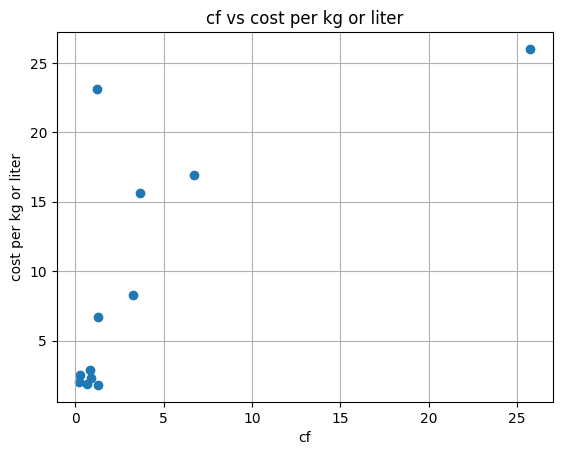

In [ ]:
plt.scatter(numeric_df["Carbon Footprint (g CO2eq/g o cc)"], numeric_df["cost_per_kg_or_l"])
plt.title("cf vs cost per kg or liter")
plt.xlabel('cf')
plt.ylabel('cost per kg or liter')
plt.grid()
plt.show()